In [53]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # <-- ADD THIS
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import os
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.20.0
GPU Available: False


In [54]:
# DATA ACQUISITION

print("=" * 60)
print("DATA ACQUISITION")
print("=" * 60)

# Load CIFAR-10 dataset (automatically downloads if not present)
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Class names: {class_names}")

DATA ACQUISITION

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


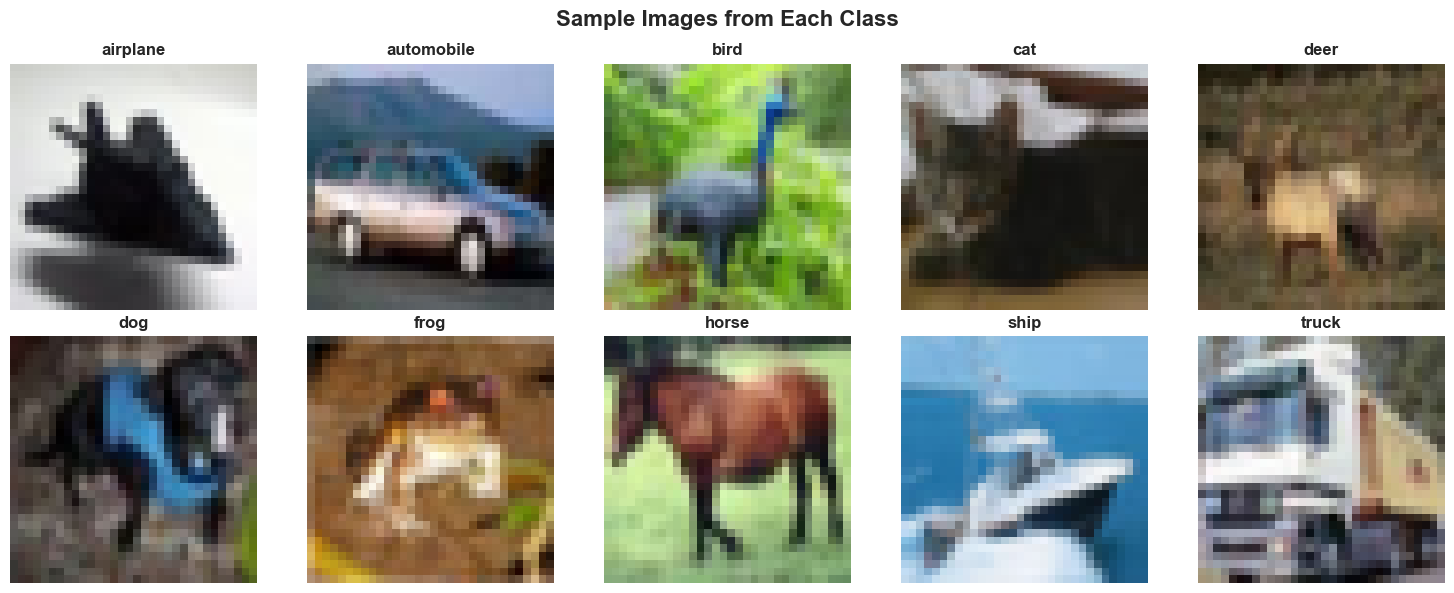


 Saved: visualization_sample_images.png


In [55]:
# 3. EXPLORATORY DATA ANALYSIS

# Visualization 1: Sample Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Get first image of each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx])
    ax.set_title(f'{class_names[i]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('visualization_sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: visualization_sample_images.png")



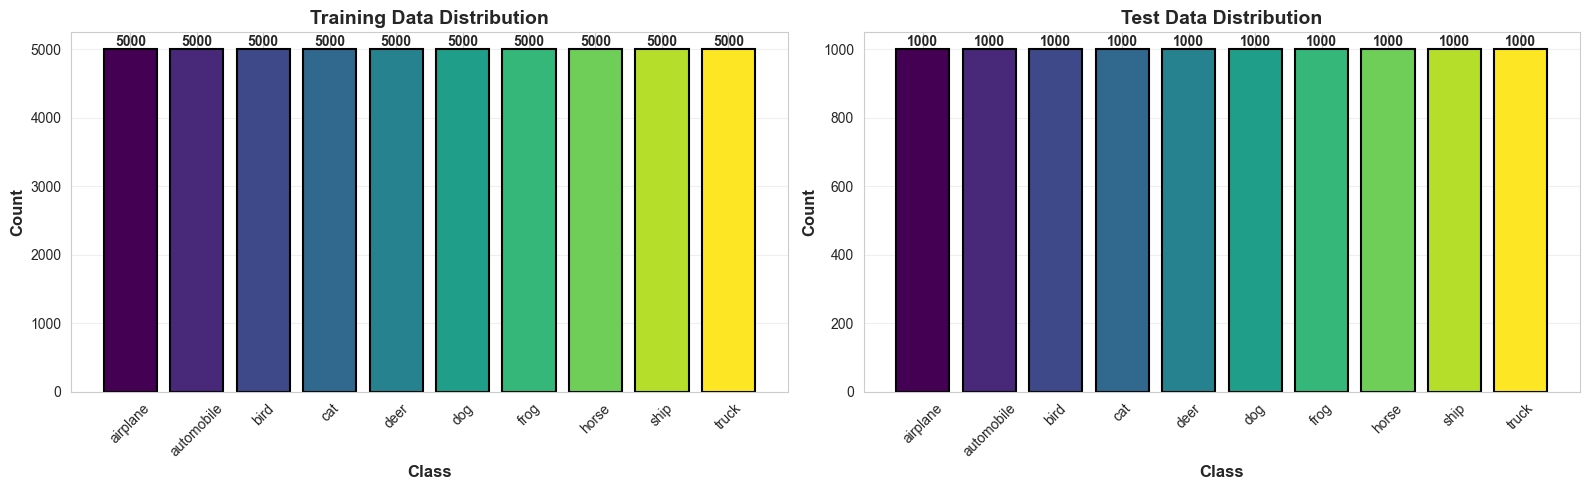

Saved: visualization_class_distribution.png

 Class Distribution Analysis:
Training samples per class: Min=5000, Max=5000
Test samples per class: Min=1000, Max=1000
 Dataset is perfectly balanced!


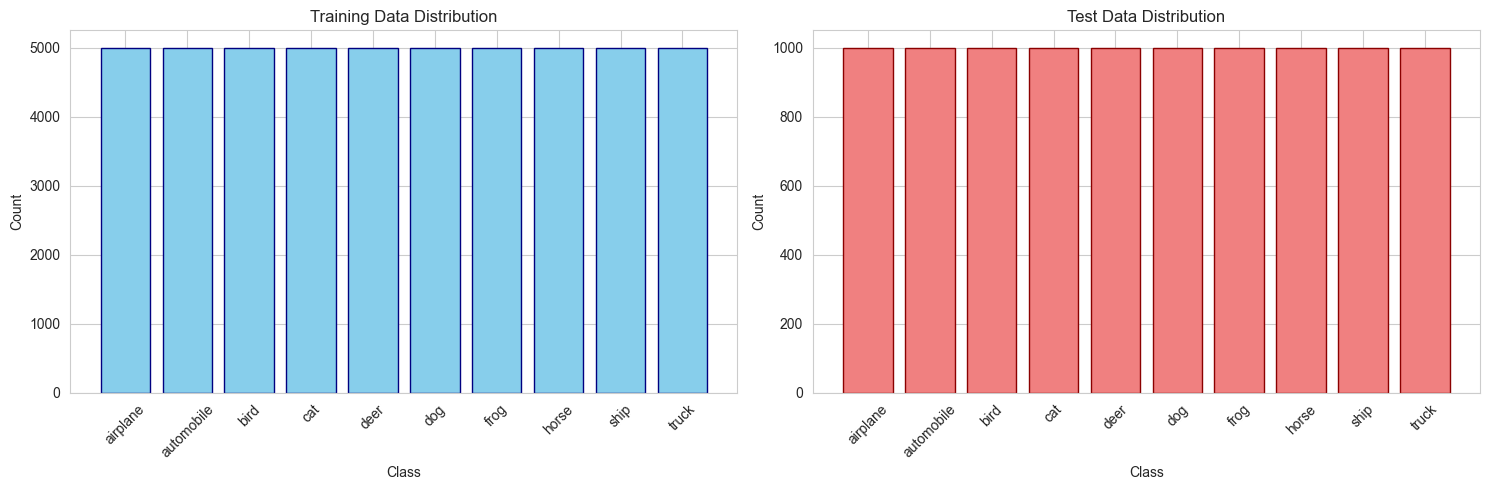

Training samples per class: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Test samples per class: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


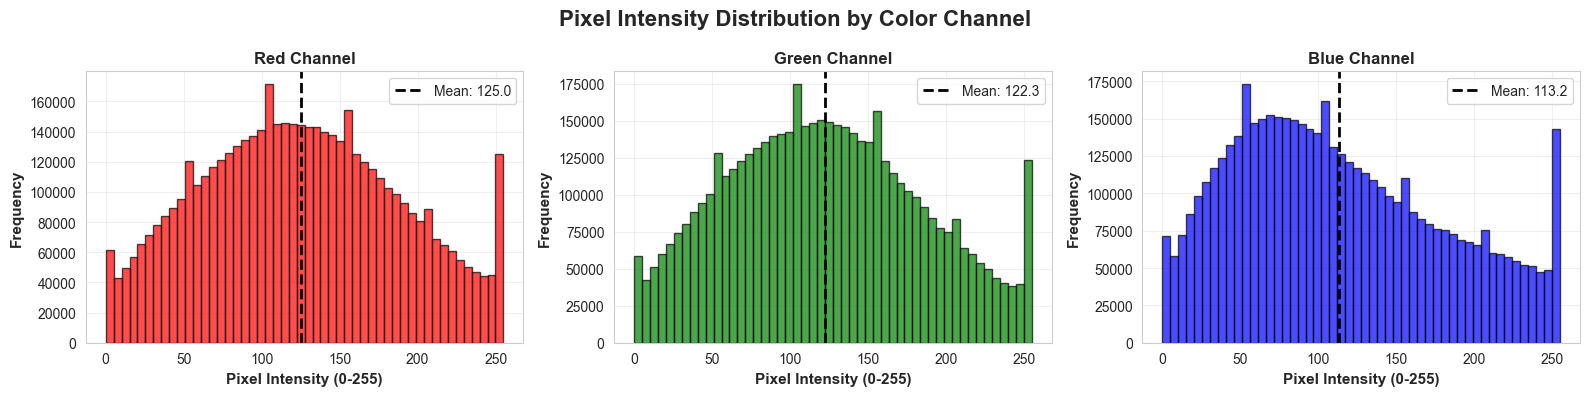

 Saved: visualization_pixel_intensity.png

 Pixel Intensity Analysis:
Red Channel - Mean: 125.31, Std: 62.99
Green Channel - Mean: 122.95, Std: 62.09
Blue Channel - Mean: 113.87, Std: 66.70


In [56]:
# Class Distribution Analysis

# Visualization 2: Class Distribution
train_counts = np.bincount(y_train.flatten())
test_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Training distribution
colors = plt.cm.viridis(np.linspace(0, 1, 10))
bars1 = ax1.bar(class_names, train_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Test distribution
bars2 = ax2.bar(class_names, test_counts, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Test Data Distribution', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: visualization_class_distribution.png")
print("\n Class Distribution Analysis:")
print(f"Training samples per class: Min={train_counts.min()}, Max={train_counts.max()}")
print(f"Test samples per class: Min={test_counts.min()}, Max={test_counts.max()}")
print(" Dataset is perfectly balanced!")
# Visualization 2: Class Distribution
train_class_counts = np.bincount(y_train.flatten())
test_class_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
ax1.bar(class_names, train_class_counts, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Training Data Distribution')
ax1.tick_params(axis='x', rotation=45)

# Test distribution
ax2.bar(class_names, test_class_counts, color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Test Data Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training samples per class: {train_class_counts}")
print(f"Test samples per class: {test_class_counts}")

#Pixel Intensity Analysis

# Visualization 3: Pixel Intensity Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Pixel Intensity Distribution by Color Channel', fontsize=16, fontweight='bold')

colors_channels = ['red', 'green', 'blue']
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']

# Sample 5000 images for analysis
sample_size = 5000
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[sample_indices]

for i, (ax, color, name) in enumerate(zip(axes, colors_channels, channel_names)):
    channel_data = X_sample[:, :, :, i].flatten()
    
    ax.hist(channel_data, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Pixel Intensity (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(channel_data)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.legend()

plt.tight_layout()
plt.savefig('visualization_pixel_intensity.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: visualization_pixel_intensity.png")
print("\n Pixel Intensity Analysis:")
for i, name in enumerate(['Red', 'Green', 'Blue']):
    channel_mean = np.mean(X_train[:, :, :, i])
    channel_std = np.std(X_train[:, :, :, i])
    print(f"{name} Channel - Mean: {channel_mean:.2f}, Std: {channel_std:.2f}")




In [57]:
# DATA PREPROCESSING

print("\n" + "=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"\nOriginal data range: [{X_train.min()}, {X_train.max()}]")
print(f"Normalized data range: [{X_train_normalized.min():.2f}, {X_train_normalized.max():.2f}]")

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"\nOriginal label shape: {y_train.shape}")
print(f"Categorical label shape: {y_train_cat.shape}")
print(" Labels converted to one-hot encoding")

# Data Augmentation
print("\n Configuring Data Augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print(" Data augmentation configured:")
print("   - Rotation: ±15 degrees")
print("   - Shift: 10% horizontal/vertical")
print("   - Horizontal flip: Yes")
print("   - Zoom: 10%")


DATA PREPROCESSING

Original data range: [0, 255]
Normalized data range: [0.00, 1.00]

Original label shape: (50000, 1)
Categorical label shape: (50000, 10)
 Labels converted to one-hot encoding

 Configuring Data Augmentation...
 Data augmentation configured:
   - Rotation: ±15 degrees
   - Shift: 10% horizontal/vertical
   - Horizontal flip: Yes
   - Zoom: 10%


In [58]:
# MODEL CREATION 

print("\n" + "=" * 60)
print("MODEL CREATION")
print("=" * 60)

def create_model(input_shape=(32, 32, 3), num_classes=10):
    """Create improved CNN model for CIFAR-10"""
    
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='CIFAR10_CNN')
    
    return model

# Create model
model = create_model()

# Display model summary
print("\n Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\n Model Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL CREATION

 Model Architecture:


Model: "CIFAR10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,662,730 (10.16 MB)

 Trainable params: 2,660,426 (10.15 MB)

 Non-trainable params: 2,304 (9.00 KB)


 Model Parameters:
Total parameters: 2,662,730
Trainable parameters: 2,660,426


In [59]:
# MODEL COMPILATION & CALLBACKS

print("\n" + "=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with:")
print(f"   - Optimizer: Adam (lr=0.001)")
print(f"   - Loss: Categorical Crossentropy")
print(f"   - Metrics: Accuracy")

# Setup callbacks - PUT IT HERE
os.makedirs('/models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '/models/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n Callbacks configured:")
print("   - Early Stopping (patience=15)")
print("   - Model Checkpoint (save best)")
print("   - Learning Rate Reduction (patience=5)")


MODEL COMPILATION
Model compiled with:
   - Optimizer: Adam (lr=0.001)
   - Loss: Categorical Crossentropy
   - Metrics: Accuracy

 Callbacks configured:
   - Early Stopping (patience=15)
   - Model Checkpoint (save best)
   - Learning Rate Reduction (patience=5)


In [60]:
# MODEL TRAINING

print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

batch_size = 64  
epochs = 50      

print(f"\n Training Configuration:")
print(f"   - Batch size: {batch_size}")
print(f"   - Epochs: {epochs}")
print(f"   - Training samples: {len(X_train_normalized)}")
print(f"   - Validation samples: {len(X_test_normalized)}")

print("\n Starting training...")
print("=" * 60)

# Train model
history = model.fit(
    datagen.flow(X_train_normalized, y_train_cat, batch_size=batch_size),
    steps_per_epoch=len(X_train_normalized) // batch_size,
    epochs=epochs,
    validation_data=(X_test_normalized, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")

# Save history
with open('/models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved")


MODEL TRAINING

 Training Configuration:
   - Batch size: 64
   - Epochs: 50
   - Training samples: 50000
   - Validation samples: 10000

 Starting training...
Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3383 - loss: 2.1409
Epoch 1: val_accuracy improved from None to 0.53830, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - accuracy: 0.4169 - loss: 1.7449 - val_accuracy: 0.5383 - val_loss: 1.3497 - learning_rate: 0.0010
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 20:37 2s/step - accuracy: 0.4688 - loss: 1.4208

c:\Users\Hp\Documents\as\MLOP_Summative\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.53830
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.4688 - loss: 1.4208 - val_accuracy: 0.5246 - val_loss: 1.3930 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.5524 - loss: 1.2480
Epoch 3: val_accuracy improved from 0.53830 to 0.59010, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 671s 859ms/step - accuracy: 0.5762 - loss: 1.1863 - val_accuracy: 0.5901 - val_loss: 1.2266 - learning_rate: 0.0010
Epoch 4/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:13 710ms/step - accuracy: 0.5625 - loss: 1.1962
Epoch 4: val_accuracy improved from 0.59010 to 0.59270, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5625 - loss: 1.1962 - val_accuracy: 0.5927 - val_loss: 1.2161 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6376 - loss: 1.0282
Epoch 5: val_accuracy improved from 0.59270 to 0.70600, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 685s 878ms/step - accuracy: 0.6465 - loss: 1.0043 - val_accuracy: 0.7060 - val_loss: 0.8328 - learning_rate: 0.0010
Epoch 6/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 21:51 2s/step - accuracy: 0.7188 - loss: 0.8778
Epoch 6: val_accuracy did not improve from 0.70600
781/781 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.7188 - loss: 0.8778 - val_accuracy: 0.7020 - val_loss: 0.8392 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.6779 - loss: 0.9168
Epoch 7: val_accuracy improved from 0.70600 to 0.74080, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 683s 874ms/step - accuracy: 0.6863 - loss: 0.8951 - val_accuracy: 0.7408 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 8/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:21 719ms/step - accuracy: 0.7188 - loss: 0.7560
Epoch 8: val_accuracy did not improve from 0.74080
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7188 - loss: 0.7560 - val_accuracy: 0.7369 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.7053 - loss: 0.8431
Epoch 9: val_accuracy did not improve from 0.74080
781/781 ━━━━━━━━━━━━━━━━━━━━ 651s 834ms/step - accuracy: 0.7065 - loss: 0.8352 - val_accuracy: 0.7127 - val_loss: 0.8270 - learning_rate: 0.0010
Epoch 10/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 8:56 688ms/step - accuracy: 0.6406 - loss: 0.9973
Epoch 10: val_accuracy did not improve from 0.74080
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.6406 - loss: 0.9973 - val_accuracy: 0.7239 - val_loss: 0.8009 - learning_rate: 0.0010
E

781/781 ━━━━━━━━━━━━━━━━━━━━ 658s 843ms/step - accuracy: 0.7273 - loss: 0.7798 - val_accuracy: 0.7428 - val_loss: 0.7538 - learning_rate: 0.0010
Epoch 12/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 8:23 646ms/step - accuracy: 0.7344 - loss: 0.6691
Epoch 12: val_accuracy did not improve from 0.74280

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7344 - loss: 0.6691 - val_accuracy: 0.7414 - val_loss: 0.7529 - learning_rate: 0.0010
Epoch 13/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.7563 - loss: 0.6984
Epoch 13: val_accuracy improved from 0.74280 to 0.78810, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 576s 738ms/step - accuracy: 0.7597 - loss: 0.6894 - val_accuracy: 0.7881 - val_loss: 0.6222 - learning_rate: 5.0000e-04
Epoch 14/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 8:14 633ms/step - accuracy: 0.7969 - loss: 0.6241
Epoch 14: val_accuracy improved from 0.78810 to 0.78830, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7969 - loss: 0.6241 - val_accuracy: 0.7883 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 15/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7769 - loss: 0.6455
Epoch 15: val_accuracy did not improve from 0.78830
781/781 ━━━━━━━━━━━━━━━━━━━━ 913s 1s/step - accuracy: 0.7766 - loss: 0.6416 - val_accuracy: 0.7633 - val_loss: 0.7083 - learning_rate: 5.0000e-04
Epoch 16/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 19:08 1s/step - accuracy: 0.7031 - loss: 0.6764
Epoch 16: val_accuracy did not improve from 0.78830
781/781 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.7031 - loss: 0.6764 - val_accuracy: 0.7614 - val_loss: 0.7133 - learning_rate: 5.0000e-04
Epoch 17/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.7837 - loss: 0.6229
Epoch 17: val_accuracy improved from 0.78830 to 0.80390, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 722s 924ms/step - accuracy: 0.7842 - loss: 0.6205 - val_accuracy: 0.8039 - val_loss: 0.5833 - learning_rate: 5.0000e-04
Epoch 18/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:45 828ms/step - accuracy: 0.6875 - loss: 0.7833
Epoch 18: val_accuracy did not improve from 0.80390
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6875 - loss: 0.7833 - val_accuracy: 0.8001 - val_loss: 0.5912 - learning_rate: 5.0000e-04
Epoch 19/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.7915 - loss: 0.6028
Epoch 19: val_accuracy did not improve from 0.80390
781/781 ━━━━━━━━━━━━━━━━━━━━ 681s 872ms/step - accuracy: 0.7930 - loss: 0.6020 - val_accuracy: 0.7801 - val_loss: 0.6791 - learning_rate: 5.0000e-04
Epoch 20/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:35 968ms/step - accuracy: 0.7812 - loss: 0.5252
Epoch 20: val_accuracy did not improve from 0.80390
781/781 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.7812 - loss: 0.5252 - val_accuracy: 0.7815 - val_loss: 0.6673 - learn

781/781 ━━━━━━━━━━━━━━━━━━━━ 671s 859ms/step - accuracy: 0.8130 - loss: 0.5374 - val_accuracy: 0.8205 - val_loss: 0.5403 - learning_rate: 2.5000e-04
Epoch 24/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:47 830ms/step - accuracy: 0.7500 - loss: 0.7528
Epoch 24: val_accuracy improved from 0.82050 to 0.82140, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7500 - loss: 0.7528 - val_accuracy: 0.8214 - val_loss: 0.5362 - learning_rate: 2.5000e-04
Epoch 25/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.8195 - loss: 0.5180
Epoch 25: val_accuracy improved from 0.82140 to 0.83180, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 787s 1s/step - accuracy: 0.8184 - loss: 0.5235 - val_accuracy: 0.8318 - val_loss: 0.4942 - learning_rate: 2.5000e-04
Epoch 26/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:04 852ms/step - accuracy: 0.8125 - loss: 0.5466
Epoch 26: val_accuracy did not improve from 0.83180
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.8125 - loss: 0.5466 - val_accuracy: 0.8310 - val_loss: 0.4979 - learning_rate: 2.5000e-04
Epoch 27/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.8252 - loss: 0.5040
Epoch 27: val_accuracy did not improve from 0.83180
781/781 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.8257 - loss: 0.5038 - val_accuracy: 0.8103 - val_loss: 0.5924 - learning_rate: 2.5000e-04
Epoch 28/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:32 888ms/step - accuracy: 0.8281 - loss: 0.4520
Epoch 28: val_accuracy did not improve from 0.83180
781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.8281 - loss: 0.4520 - val_accuracy: 0.8084 - val_loss: 0.5959 - learning_ra

781/781 ━━━━━━━━━━━━━━━━━━━━ 725s 929ms/step - accuracy: 0.8278 - loss: 0.4958 - val_accuracy: 0.8399 - val_loss: 0.4818 - learning_rate: 2.5000e-04
Epoch 30/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:29 884ms/step - accuracy: 0.8125 - loss: 0.6035
Epoch 30: val_accuracy did not improve from 0.83990
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8125 - loss: 0.6035 - val_accuracy: 0.8396 - val_loss: 0.4825 - learning_rate: 2.5000e-04
Epoch 31/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.8314 - loss: 0.4826
Epoch 31: val_accuracy did not improve from 0.83990
781/781 ━━━━━━━━━━━━━━━━━━━━ 686s 878ms/step - accuracy: 0.8316 - loss: 0.4883 - val_accuracy: 0.8259 - val_loss: 0.5328 - learning_rate: 2.5000e-04
Epoch 32/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:09 935ms/step - accuracy: 0.8125 - loss: 0.5981
Epoch 32: val_accuracy did not improve from 0.83990
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8125 - loss: 0.5981 - val_accuracy: 0.8283 - val_loss: 0.5230 - learn

781/781 ━━━━━━━━━━━━━━━━━━━━ 697s 893ms/step - accuracy: 0.8399 - loss: 0.4600 - val_accuracy: 0.8473 - val_loss: 0.4631 - learning_rate: 1.2500e-04
Epoch 36/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:05 931ms/step - accuracy: 0.9062 - loss: 0.3325
Epoch 36: val_accuracy did not improve from 0.84730
781/781 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9062 - loss: 0.3325 - val_accuracy: 0.8471 - val_loss: 0.4623 - learning_rate: 1.2500e-04
Epoch 37/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8436 - loss: 0.4517
Epoch 37: val_accuracy improved from 0.84730 to 0.85350, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 711s 910ms/step - accuracy: 0.8437 - loss: 0.4521 - val_accuracy: 0.8535 - val_loss: 0.4384 - learning_rate: 1.2500e-04
Epoch 38/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:15 942ms/step - accuracy: 0.8438 - loss: 0.4584
Epoch 38: val_accuracy improved from 0.85350 to 0.85380, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8438 - loss: 0.4584 - val_accuracy: 0.8538 - val_loss: 0.4371 - learning_rate: 1.2500e-04
Epoch 39/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8459 - loss: 0.4467
Epoch 39: val_accuracy did not improve from 0.85380
781/781 ━━━━━━━━━━━━━━━━━━━━ 761s 975ms/step - accuracy: 0.8457 - loss: 0.4436 - val_accuracy: 0.8535 - val_loss: 0.4421 - learning_rate: 1.2500e-04
Epoch 40/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 14:20 1s/step - accuracy: 0.7500 - loss: 0.7597
Epoch 40: val_accuracy did not improve from 0.85380
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.7500 - loss: 0.7597 - val_accuracy: 0.8534 - val_loss: 0.4426 - learning_rate: 1.2500e-04
Epoch 41/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.8459 - loss: 0.4422
Epoch 41: val_accuracy improved from 0.85380 to 0.86030, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - accuracy: 0.8477 - loss: 0.4420 - val_accuracy: 0.8603 - val_loss: 0.4188 - learning_rate: 1.2500e-04
Epoch 42/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:48 908ms/step - accuracy: 0.9219 - loss: 0.3382
Epoch 42: val_accuracy improved from 0.86030 to 0.86070, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9219 - loss: 0.3382 - val_accuracy: 0.8607 - val_loss: 0.4195 - learning_rate: 1.2500e-04
Epoch 43/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.8495 - loss: 0.4366
Epoch 43: val_accuracy improved from 0.86070 to 0.86520, saving model to /models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 714s 914ms/step - accuracy: 0.8495 - loss: 0.4357 - val_accuracy: 0.8652 - val_loss: 0.4079 - learning_rate: 1.2500e-04
Epoch 44/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:03 928ms/step - accuracy: 0.9219 - loss: 0.2649
Epoch 44: val_accuracy did not improve from 0.86520
781/781 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9219 - loss: 0.2649 - val_accuracy: 0.8652 - val_loss: 0.4079 - learning_rate: 1.2500e-04
Epoch 45/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8506 - loss: 0.4255
Epoch 45: val_accuracy did not improve from 0.86520
781/781 ━━━━━━━━━━━━━━━━━━━━ 748s 957ms/step - accuracy: 0.8507 - loss: 0.4311 - val_accuracy: 0.8517 - val_loss: 0.4502 - learning_rate: 1.2500e-04
Epoch 46/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 13:35 1s/step - accuracy: 0.8281 - loss: 0.4754
Epoch 46: val_accuracy did not improve from 0.86520
781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.8281 - loss: 0.4754 - val_accuracy: 0.8511 - val_loss: 0.4494 - learning


TRAINING VISUALIZATION


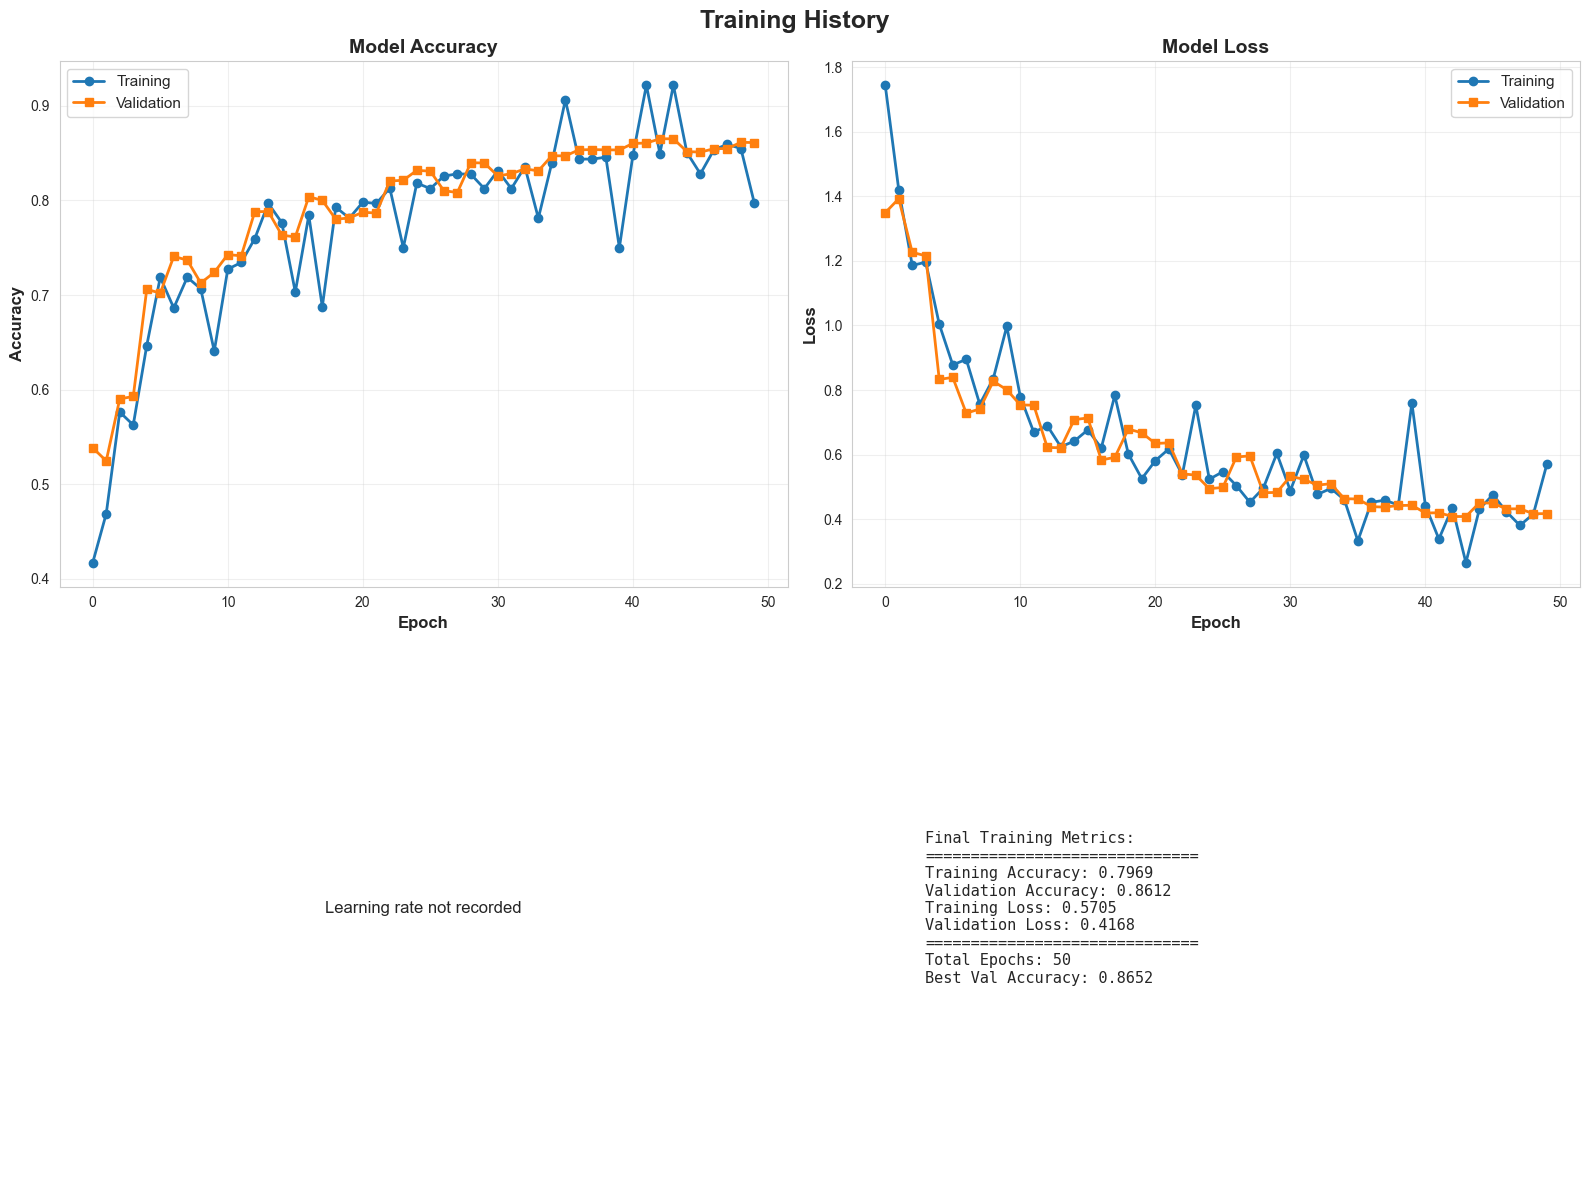

 Saved: training_history.png


In [61]:
# TRAINING VISUALIZATION

print("\n" + "=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training History', fontsize=18, fontweight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2, marker='o')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2, marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, marker='o', color='orange')
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate not recorded', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

summary_text = f"""
Final Training Metrics:
{'='*30}
Training Accuracy: {final_train_acc:.4f}
Validation Accuracy: {final_val_acc:.4f}
Training Loss: {final_train_loss:.4f}
Validation Loss: {final_val_loss:.4f}
{'='*30}
Total Epochs: {len(history.history['accuracy'])}
Best Val Accuracy: {max(history.history['val_accuracy']):.4f}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: training_history.png")


=== MODEL EVALUATION ===

 Making predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step

FINAL MODEL PERFORMANCE METRICS
Accuracy:  0.8652 (86.52%)
Precision: 0.8696 (86.96%)
Recall:    0.8652 (86.52%)
F1-Score:  0.8637 (86.37%)

 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.89      0.89      1000
  automobile       0.93      0.96      0.94      1000
        bird       0.88      0.78      0.83      1000
         cat       0.84      0.66      0.74      1000
        deer       0.84      0.86      0.85      1000
         dog       0.86      0.76      0.80      1000
        frog       0.72      0.98      0.83      1000
       horse       0.88      0.91      0.90      1000
        ship       0.95      0.93      0.94      1000
       truck       0.91      0.94      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg   

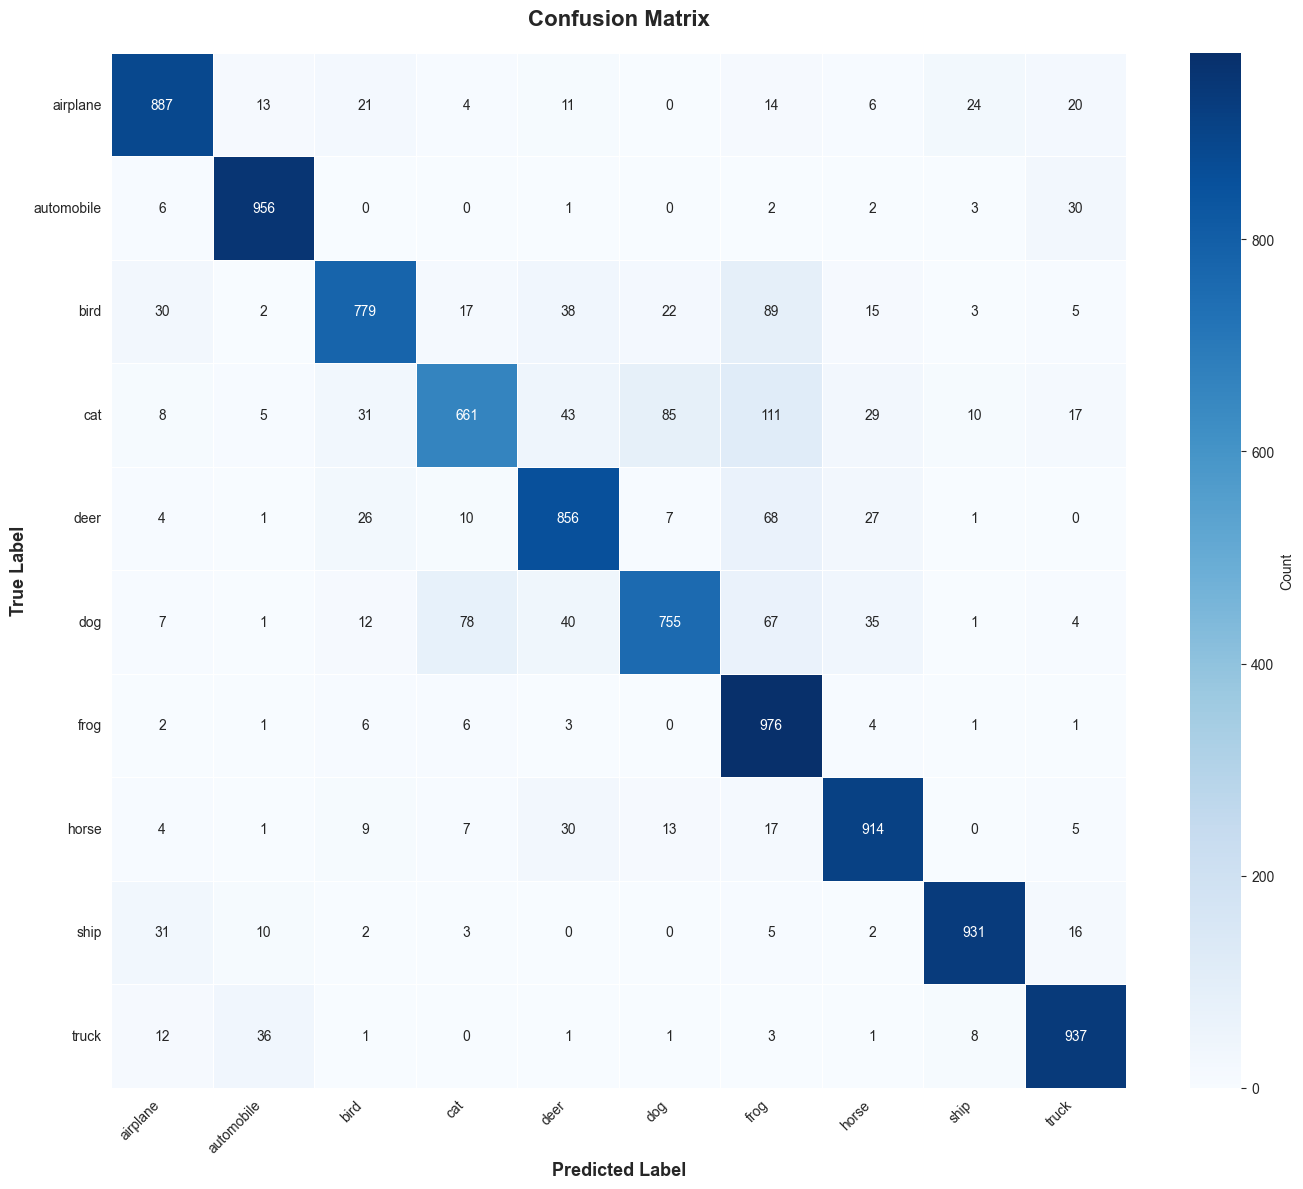

 Saved: confusion_matrix.png


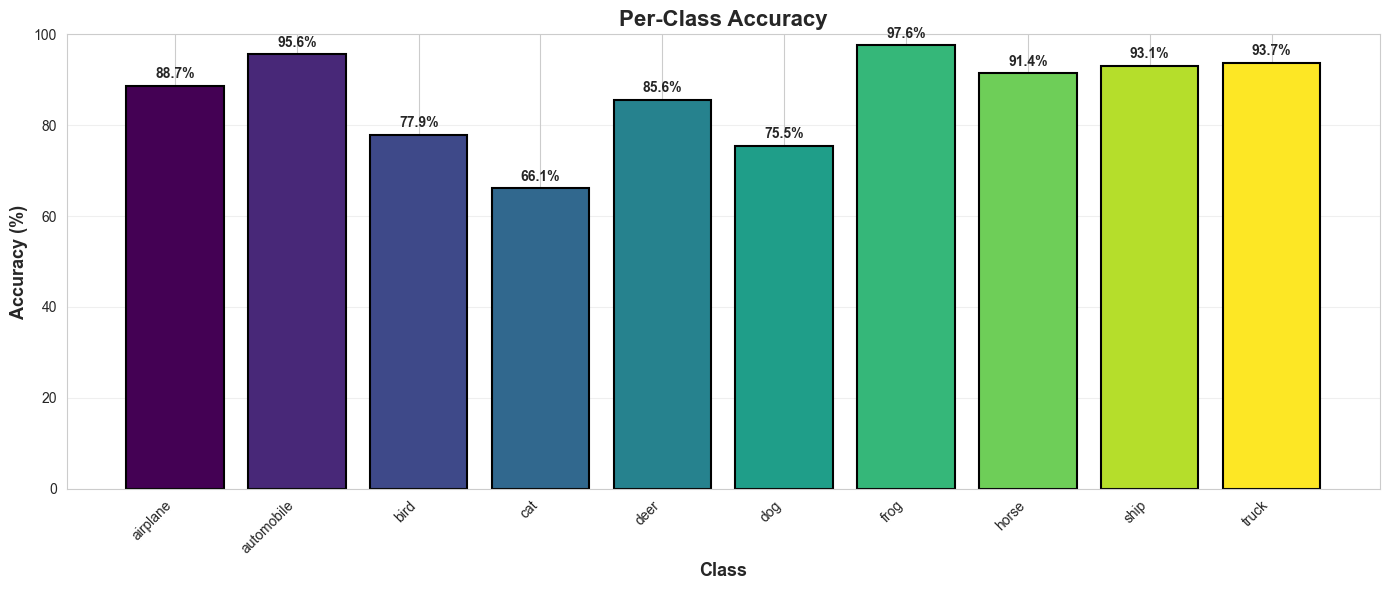

Saved: per_class_accuracy.png

 Per-Class Performance:
airplane    : 88.70%
automobile  : 95.60%
bird        : 77.90%
cat         : 66.10%
deer        : 85.60%
dog         : 75.50%
frog        : 97.60%
horse       : 91.40%
ship        : 93.10%
truck       : 93.70%


In [62]:
# MODEL EVALUATION

print("\n=== MODEL EVALUATION ===")

# Make predictions
print("\n Making predictions on test set...")
y_pred_probs = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("=" * 60)

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#  Confusion Matrix
print("\n Creating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix.png")

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy * 100, 
               color=plt.cm.viridis(np.linspace(0, 1, 10)),
               edgecolor='black', linewidth=1.5)
plt.xlabel('Class', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: per_class_accuracy.png")

print("\n Per-Class Performance:")
for i, name in enumerate(class_names):
    print(f"{name:12s}: {class_accuracy[i]*100:.2f}%")

In [63]:
# SAVE MODEL 

print("\n" + "=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('/models', exist_ok=True)

# Save in H5 format (this is enough for the project)
model_h5_path = '/models/cifar10_classifier.h5'
model.save(model_h5_path)
print(f"Saved H5 model: {model_h5_path}")

# Save metadata
metadata = {
    'class_names': class_names,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_params': int(total_params),
    'trainable_params': int(trainable_params)
}

with open('/models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Saved model metadata")

print("\n Files created:")
print(f"   - {model_h5_path}")
print(f"   - /models/model_metadata.pkl")
print(f"   - /models/training_history.pkl")


SAVING MODEL
Saved H5 model: /models/cifar10_classifier.h5
Saved model metadata

 Files created:
   - /models/cifar10_classifier.h5
   - /models/model_metadata.pkl
   - /models/training_history.pkl



TESTING PREDICTION FUNCTION

 Testing predictions on random test images:



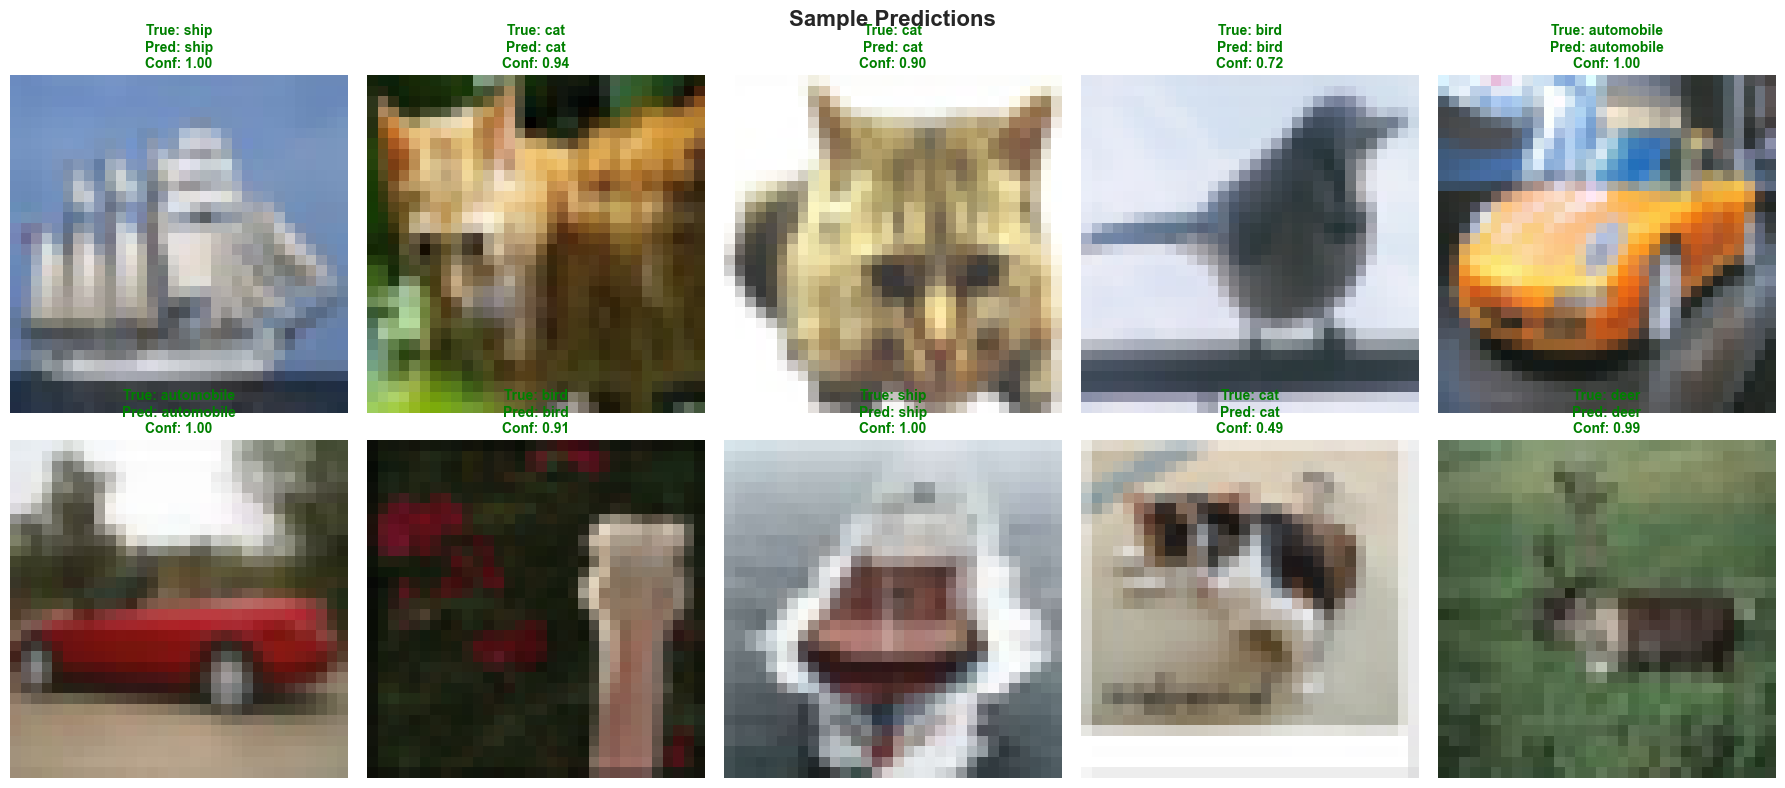

 Saved: sample_predictions.png

 Final Results:
   - Accuracy: 86.52%
   - Precision: 86.96%
   - Recall: 86.52%
   - F1-Score: 86.37%


In [64]:
# TEST PREDICTION FUNCTION

print("\n" + "=" * 60)
print("TESTING PREDICTION FUNCTION")
print("=" * 60)

def predict_image(model, image, class_names):
    """Predict class of a single image"""
    if image.shape != (32, 32, 3):
        raise ValueError(f"Image must be (32,32,3), got {image.shape}")
    
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch, verbose=0)
    
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    
    all_predictions = [
        {'class': class_names[i], 'confidence': float(predictions[0][i])}
        for i in range(len(class_names))
    ]
    all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {
        'predicted_class': class_names[predicted_idx],
        'confidence': float(confidence),
        'all_predictions': all_predictions
    }

# Test on random images
print("\n Testing predictions on random test images:\n")

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test_normalized))
    test_image = X_test_normalized[idx]
    true_label = class_names[y_test[idx][0]]
    
    result = predict_image(model, test_image, class_names)
    pred_label = result['predicted_class']
    confidence = result['confidence']
    
    ax.imshow(X_test[idx])
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: sample_predictions.png")

print("\n Final Results:")
print(f"   - Accuracy: {accuracy*100:.2f}%")
print(f"   - Precision: {precision*100:.2f}%")
print(f"   - Recall: {recall*100:.2f}%")
print(f"   - F1-Score: {f1*100:.2f}%")
